## Import Required Modules

In [1]:
import os
import sys
import numpy as np
import random
from audio import read_mfcc
from batcher import sample_from_mfcc
from constants import SAMPLE_RATE, NUM_FRAMES
from conv_models import DeepSpeakerModel
from scipy.stats import entropy
import tensorflow as tf
import torch
import torch.nn as nn
import torch.nn.functional as F
import logging
import matplotlib.pyplot as plt
from tabulate import tabulate
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch.optim as optim

Using TensorFlow backend.


## Setup Environment

In [2]:
np.random.seed(1234)
random.seed(1234)

In [3]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
logging.getLogger('tensorflow').setLevel(logging.FATAL)

## Load Dataset 

In [4]:
class ClassifierDataset(Dataset):
    """Load numpy files from directory structure where each numpy file represents
    the extracted features from the pre-trained model"""
    
    def __init__(self, positive_labels, negative_labels, num_shots=2, train=False):
        outputs = []
        labels = []

        positive_labels = [f for f in positive_labels if f != '.DS_Store']

        for i, speaker_dir in enumerate(positive_labels):
            relative_path = f'mfcc/split/Accents/{speaker_dir}'
            samples = os.listdir(relative_path)

            sample_range = range(num_shots) if train else range(num_shots, len(samples))
            for j in sample_range:
                output = np.load(f'{relative_path}/Accents_{j}.npy')[0]
                outputs.append(output)
                labels.append(i)
                
        negative_index = labels[-1] + 1
        negative_labels = [f for f in negative_labels if f != '.DS_Store']

        for speaker_dir in negative_labels:
            relative_path = f'mfcc/split/Accents/{speaker_dir}'
            samples = os.listdir(relative_path)
            
            sample_range = range(num_shots) if train else range(num_shots)
            for j in sample_range:
                output = np.load(f'{relative_path}/Accents_{j}.npy')[0]
                outputs.append(output)
                labels.append(negative_index)
             
        self.outputs = np.array(outputs)
        self.labels = np.array(labels)

    def __len__(self):
        return len(self.outputs)

    def __getitem__(self, idx):
        return torch.tensor(self.outputs[idx]), self.labels[idx]

In [5]:
def generate_dataloaders(count=None, junk_count=None, min_clips=3, num_shots=1):
    accents_mfcc = [f for f in os.listdir('mfcc/split/Accents') if f != '.DS_Store']
    
    filtered_accents_mfcc = [s for s in accents_mfcc if len(os.listdir(f'mfcc/split/Accents/{s}')) >= min_clips]
    
    random.shuffle(filtered_accents_mfcc)

    num_segments = 2

    split_data = np.array_split(filtered_accents_mfcc, num_segments)

    # needed to know how many output neurons for classifier
    classifier_classes = split_data[0]
    junk_data = split_data[1]
  
    junk_data_1, junk_data_2 = np.array_split(junk_data, 2)
    
    # use a subset of the data based on count
    if count:
        classifier_classes = classifier_classes[:count]
        
    if junk_count:
        junk_data_1 = junk_data_1[:junk_count]
        #junk_data_2 = junk_data_2[:junk_count]

    batch_size = 16

    if count and len(classifier_classes) < count:
        print(f'WARNING: Count is higher than number of classes available: {len(classifier_classes)}')
        
    classifier_training_dataset = ClassifierDataset(classifier_classes, junk_data_1, num_shots=num_shots, train=True)
    classifier_testing_dataset = ClassifierDataset(classifier_classes, junk_data_2, num_shots=num_shots, train=False)
    
    classifier_training_loader = DataLoader(classifier_training_dataset, batch_size=batch_size)
    classifier_testing_loader = DataLoader(classifier_testing_dataset, batch_size=batch_size)


    return classifier_training_loader, classifier_testing_loader


In [6]:
class Classifier(nn.Module):
    """Define a simple linear neural network

    Args:
        num_classes: the number of classes we are classifying

    """
    
    def __init__(self, num_classes):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(512, num_classes)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.softmax(x, dim=1)
        
        return x

In [26]:
def train_classifier(classifier_training_loader, classifier_validation_loader, subject_weight, junk_weight, num_classes, num_epochs=1000, lr=0.003):
    classifier = Classifier(num_classes=num_classes)

    train_losses = []
    validation_losses = []
    
    weights = [subject_weight] * num_classes
    weights[-1] = junk_weight
    weights = torch.from_numpy(np.array(weights)).type(torch.FloatTensor)

    criterion = nn.CrossEntropyLoss(weight=weights, reduction='mean')
    optimizer = optim.Adam(classifier.parameters(), lr=lr)

    for epoch_num, epoch in enumerate(range(num_epochs)):
        train_loss = 0.0
        validation_loss = 0.0

        classifier.train()
        for batch_index, (inputs, labels) in enumerate(classifier_training_loader):
            optimizer.zero_grad()

            outputs = classifier(inputs)

            loss = criterion(outputs, labels)
            loss.backward()
            train_loss += loss.item() * inputs.size(0)            
            optimizer.step()

        classifier.eval()
        for batch_index, (inputs, labels) in enumerate(classifier_validation_loader):
            optimizer.zero_grad()
            outputs = classifier(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            validation_loss += loss.item() * inputs.size(0)
            optimizer.step()

        train_loss = train_loss / len(classifier_training_loader)
        validation_loss = validation_loss / len(classifier_validation_loader)

        train_losses.append(train_loss)
        validation_losses.append(validation_loss)

    plt.title('Validation and Training Loss')
    plt.xlabel('Training Epochs')
    plt.ylabel('Loss')
    plt.plot(train_losses, label='Train')
    plt.plot(validation_losses, label='Validation')
    plt.legend()
    plt.show()
    return classifier

In [27]:
from sklearn.metrics import f1_score


def test_classifier(classifier, classifier_testing_loader, count, output_stats=False):
    class_correct = [0] * count
    class_total = [0] * count
    
    # used to calculate global f1
    all_labels = []
    all_predicted = []

    with torch.no_grad():
        for data in classifier_testing_loader:
            images, labels = data
            outputs = classifier(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            
            all_labels += labels
            all_predicted += predicted
            
            """
            for i, (output, label) in enumerate(zip(outputs, labels)):
                class_total[label] += 1
                class_correct[label] += c[i].item()
            """

    f1 = f1_score(all_labels, all_predicted, average='weighted')

    if output_stats:
        print(f'f1: {f1}')
        
    return f1

In [28]:
def pipeline(count, subject_weight, junk_weight, junk_count=30, min_clips=3, num_shots=1):
    classifier_training_loader, classifier_testing_loader = generate_dataloaders(count=count, junk_count=junk_count, min_clips=min_clips, num_shots=num_shots)
    # using test set as validation set
    classifier = train_classifier(classifier_training_loader, classifier_testing_loader, subject_weight, junk_weight, count + 1)
    
    # find optimal thresholds
    f1 = test_classifier(classifier, classifier_testing_loader, count + 1, output_stats=False)

    return f1

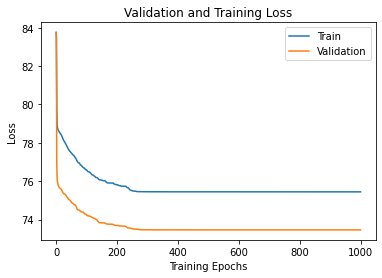

New high f1 (200): 0.5493730551369708, (200, 3, 100), (2 shots)


KeyboardInterrupt: 

In [29]:
highest_f1 = 0
# (subject count, num clips, junk count)
highest_values = (None, None, None)

max_subject_counts = {
    2: 900,
    3: 299,
    4: 80
}

num_clips = 3

NUM_SHOTS = 2

max_f1_per_subject_count = {}
values_per_subject_count = {}

for subject_count in range(200, max_subject_counts[NUM_SHOTS + 1], 50):
    #for num_clips in [NUM_SHOTS + 1]:
    max_subject_count = max_subject_counts[num_clips]
    if subject_count > max_subject_count:
        continue

    for junk_count in range(int(subject_count / 2), int(subject_count * 2), 10):
        subject_weight = junk_count / num_clips
        junk_weight = 1

        f1 = pipeline(subject_count, subject_weight=subject_weight, junk_weight=junk_weight, junk_count=junk_count, min_clips=num_clips, num_shots=NUM_SHOTS)

        if f1 > max_f1_per_subject_count.get(subject_count, 0):
            values = (subject_count, num_clips, junk_count)
            print(f'New high f1 ({subject_count}): {f1}, {values}, ({NUM_SHOTS} shots)')
            max_f1_per_subject_count[subject_count] = f1
            values_per_subject_count[subject_count] = values